In [1]:
 #visualization tool for displaying long load/processing times
!pip install tqdm --quiet
#data processing
!pip install pandas --quiet
#workhorse for converting text into embeddings/vectors
!pip install sentence-transformers==2.2.2 --quiet
#data framework for LLM applications
!pip install llama-index==0.9.29  --quiet
#logging output
!pip install loguru==0.7.0 --quiet
#convenient pretty printing library
!pip install rich --quiet
#openai Tokenizer library
!pip install tiktoken --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 918.4 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.8/15.8 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.5/327.5 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 223.4 kB/s eta 0:00:00


In [15]:
!curl -o Data_Med.json https://raw.githubusercontent.com/paramjeetn/Doctor_Copilot_V1/main/Data/Data_Med.json


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  101k  100  101k    0     0   443k      0 --:--:-- --:--:-- --:--:--  442k


In [16]:
%load_ext autoreload
%autoreload 2

#standard libraries
import sys
sys.path.append('../')

import json
import os
import time
from typing import List, Tuple
from math import ceil

#external libraries
import pandas as pd
import numpy as np
from rich import print
from rich.pretty import pprint #nifty library for pretty printing
from torch import cuda
from tqdm import tqdm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#root folder on Google Colab is: /content/
root_folder = '/content/'  #'../data'
data_file = 'Data_Med.json'
data_path = os.path.join(root_folder, data_file)


In [18]:
def load_json(file_path: str) -> list[dict]:
  with open(file_path) as f:
    data = json.load(f)
  return data

data = load_json(data_path)
print(f'Total # of papers: {len(data)}')

Total # of papers: 14

In [ ]:
print(data[0])

In [19]:
contents = [d['content'] for d in data]
content_lengths = [len(content.split()) for content in contents]
df = pd.DataFrame(content_lengths, columns=['# Words'])
df.describe()

,# Words
count,14.000000
mean,862.285714
std,423.422580
min,362.000000
25%,639.000000
50%,789.500000
75%,1025.750000
max,2116.000000


In [ ]:
print(contents[:2])

In [21]:
#Tokenisation not needed for chroma
from llama_index.text_splitter import SentenceSplitter #one of the best on the market

#set chunk size and instantiate your SentenceSplitter
chunk_size = 256
gpt35_txt_splitter = SentenceSplitter(chunk_size=chunk_size, chunk_overlap=0)


In [22]:
def split_contents(corpus: list[dict],
                   text_splitter: SentenceSplitter,
                   content_field: str='content'
                   ) -> list[list[str]]:

    return [text_splitter.split_text(d[content_field]) for d in corpus]


In [23]:
content_splits = split_contents(data, gpt35_txt_splitter,'content')
print(content_splits[0])

[
    'Diagnosis and Classification of Diabetes (A) Diagnostic Tests for Diabetes: i)A1C Prediabetes: 5.7–6.4% (39–47
mmol/ mol) Diabetes: ≥6.5% (≥48 mmol/mol) ii) 2-hour glucose value during a 75-g oral glucose tolerance test 
Prediabetes: 140–199 mg/dL (7.8–11.0 mmol/L) Diabetes: ≥200 mg/dL (≥11.1 mmol/L) iii)Fasting plasma glucose 
Prediabetes: 100–125 mg/dL (5.6–6.9 mmol/L) Diabetes: ≥126 mg/dL (≥7.0 mmol/L) iv)Random glucose value with classic
hyperglycemia symptoms/ hyperglycemic crisis Diabetes: ≥200 mg/dL (≥11.1 mmol/L) • There is insufficient evidence 
to support the use of continuous glucose monitoring for screening or diagnosing prediabetes or diabetes.',
    '• In the absence of unequivocal hyperglycemia (e.g., hyperglycemic crisis), diagnosis of type 2 diabetes 
requires confirmatory testing, which can be a different test on the same day or the same test on a different day. •
Marked discordance between A1C and repeated blood (B) Classification Classification of diabetes type is not always 
straightforward at presentation, and misdiagnosis is common. i)Type 1 diabetes (idiopathic or autoimmune β-cell 
destruction) ii)Type 2 diabetes (non-autoimmune progressive loss of adequate β-cell insulin secretion frequently on
the background of insulin resistance and metabolic syndrome) iii)Gestational diabetes mellitus (GDM; detected at 
24–28 weeks of gestation in individuals without previously identified diabetes or high-risk glucose metabolism) 
iv)Diabetes from other causes (e.g., monogenic diabetes syndromes, diseases of the exocrine pancreas, and drug- or 
chemical-induced diabetes) (C)Screening Criteria for Prediabetes and Type 2 Diabetes: Screening for prediabetes and
type 2 diabetes should be performed in asymptomatic adults with an informal assessment of risk factors or a 
validated risk calculator.',
    '(D)Informal Risk Factor Assessment for Prediabetes and Type 2 Diabetes i) Everyone ≥35 years of age ii)People 
with prior GDM iii)History of prediabetes iv)People with HIV, exposure to high-risk medicines, or a history of 
pancreatitis. Adults (≥18 years of age) with overweight or obesity (BMI ≥25 kg/m2 or ≥23 kg/m2 in Asian American 
individuals) who have one or more of the following risk factors: ʜ First-degree relative with diabetes ʜ High-risk 
race/ethnicity ʜ History of cardiovascular disease ʜ Hypertension (≥130/80 mmHg or on therapy for hypertension) ʜ 
Polycystic ovary syndrome ʜ HDL cholestorol <35 mg/dL (<0.9 mmol/L) and/or trigylcerides >250 mg/dL (>2.8 mmol/L) ʜ
Physical inactivity ʜ Other clinical conditions associated with insulin resistance (E) Clinical Notes i) If results
are normal, repeat screening at least every 3 years (annually for those with prediabetes), or sooner with symptoms 
or changes in risk.',
    'ii) Risk-based screening for prediabetes or type 2 diabetes should be considered after the onset of puberty or
after 10 years of age, whichever occurs earlier, in children and adolescents with overweight (BMI ≥85th percentile)
or obesity (BMI ≥95th percentile) who have one or more risk factors for diabetes. (F) i) (a) condition: An altered 
relationship between A1C and glycemia (b) clinical tips: A mismatch between A1C and glycemia could be caused by 
some hemoglobin variants, pregnancy (second and third trimesters and the postpartum period), glucose-6-phosphate 
dehydrogenase deficiency, HIV, hemodialysis, recent blood loss or transfusion, anemia, or erythropoietin therapy. 
People with HIV should be screened for diabetes and prediabetes before and 3–6 months after starting or changing 
antiretroviral therapy and annually if initial results are normal. (c) best test:Fasting plasmaglucose ii) (a) 
condition: Acute pancreatitis (b) clinical tips: Screen for diabetes 3-6 months after an episode of acute 
pancreatitis and annually thereafter.',
    '(c) best test: Any standard test for diagnosing diabetes iii) (a) condition: Cystic fibrosis (b) clinical 
tips: Annual screening should begin by

In [ ]:
#helper function to capture the lengths of each split

def get_split_lengths(splits: List[List[str]], column_name: str='Split Lengths') -> pd.DataFrame:
    '''
    Given a list of text splits, returns the length of each split
    in a pandas DataFrame.
    '''
    lengths = list(map(len, splits))
    return pd.DataFrame(lengths, columns=[column_name])

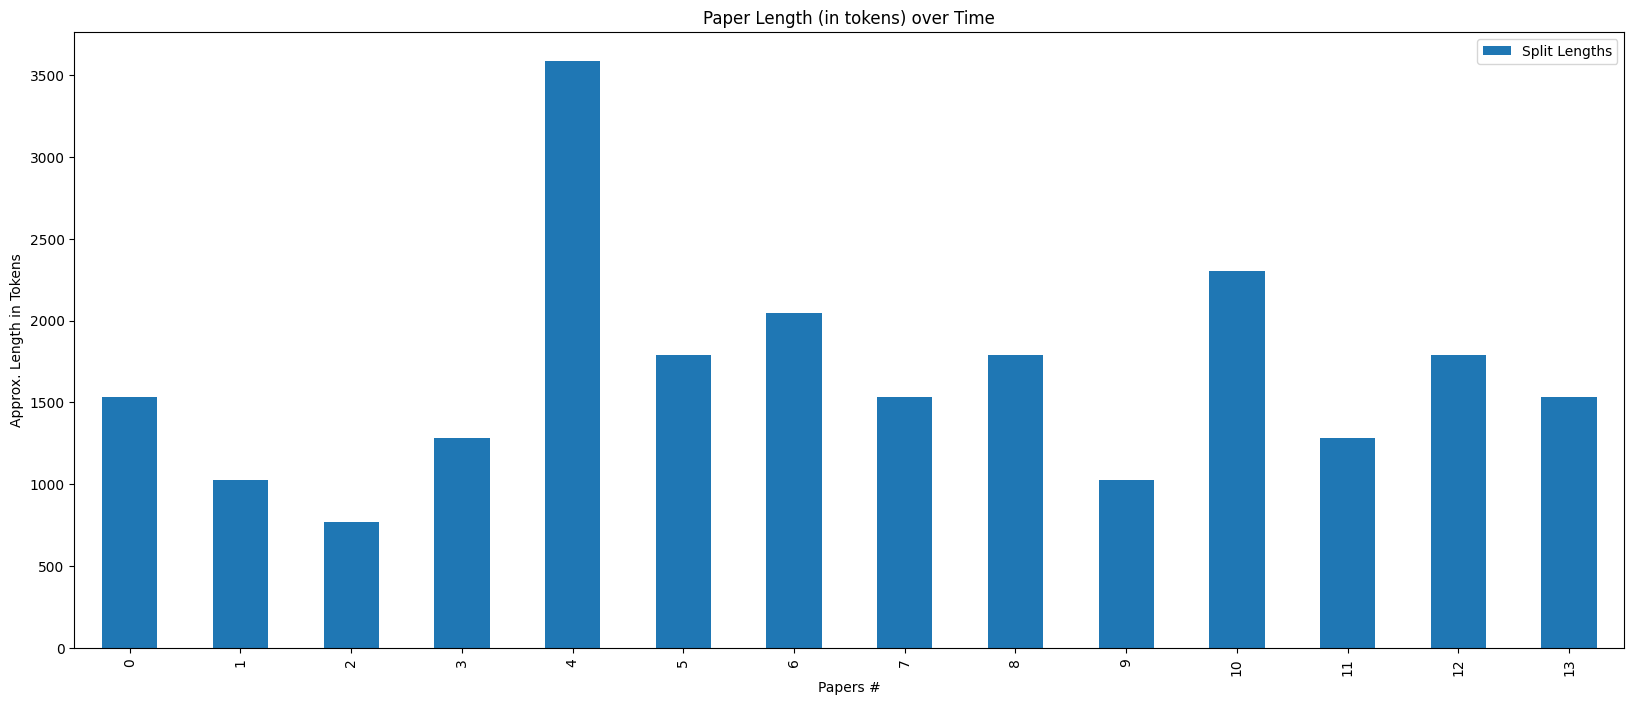

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

column_name = 'Split Lengths'

# replace None with the output from the split_contents function
df = get_split_lengths(content_splits , column_name=column_name)
df['Split Lengths'] = df['Split Lengths'] * chunk_size

# reverse the order of the episode # to correctly show left to right chronological order
df.index = sorted(list(df.index), reverse=True)
# create plot
ax = df.iloc[::-1].plot.bar(y='Split Lengths', xlabel='Papers #', ylabel='Approx. Length in Tokens', title='Paper Length (in tokens) over Time', figsize=(20,8))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

In [28]:
def join_metadata(data: list[dict], content_splits: list[list[str]]) -> list[dict]:

    joined_documents = []

    for i, episode in enumerate(data):
        for j, text in enumerate(content_splits[i]):
            new_doc = {}
            new_doc["doc_id"] = data[i]["doc_id"]
            new_doc["content_id"] = data[i]["doc_id"] + "_cont_" + str(j+1)
            new_doc["doc_name"] = data[i]["doc_name"]
            new_doc["summary"] = data[i]["Summary"]
            new_doc["content"] = text
            joined_documents.append(new_doc)

    return joined_documents

In [29]:
docs = join_metadata(data, content_splits )
print(docs)

[
    {
        'doc_id': 'd_1',
        'content_id': 'd_1_cont_1',
        'doc_name': 'Diagnosis and Classification of Diabetes',
        'summary': "The document outlines the diagnostic criteria and classification for diabetes, emphasizing 
various tests such as the A1C, where a level of ≥6.5% indicates diabetes; the 2-hour glucose value during an oral 
glucose tolerance test with a threshold of ≥200 mg/dL for diabetes; fasting plasma glucose, where diabetes is 
diagnosed at ≥126 mg/dL; and random glucose testing, which diagnoses diabetes at ≥200 mg/dL in the presence of 
symptoms. It notes the limitations of continuous glucose monitoring in diagnosing prediabetes and diabetes, and the
necessity for confirmatory testing in ambiguous cases. The classification section details different types of 
diabetes including Type 1, Type 2, gestational, and other causes such as genetic syndromes. Screening is 
recommended for adults based on risk factors, with specific guidelines for assessing risks such as age, prior 
gestational diabetes, and other health conditions. Clinical notes suggest repeat screening every three years for 
normal results, and more frequently for those with prediabetes or changing symptoms. Special circumstances, like 
hemoglobin variants or post-transplant status, may alter screening methods, with various specific tests recommended
based on the individual's condition and risk factors.",
        'content': 'Diagnosis and Classification of Diabetes (A) Diagnostic Tests for Diabetes: i)A1C Prediabetes: 
5.7–6.4% (39–47 mmol/ mol) Diabetes: ≥6.5% (≥48 mmol/mol) ii) 2-hour glucose value during a 75-g oral glucose 
tolerance test Prediabetes: 140–199 mg/dL (7.8–11.0 mmol/L) Diabetes: ≥200 mg/dL (≥11.1 mmol/L) iii)Fasting plasma 
glucose Prediabetes: 100–125 mg/dL (5.6–6.9 mmol/L) Diabetes: ≥126 mg/dL (≥7.0 mmol/L) iv)Random glucose value with
classic hyperglycemia symptoms/ hyperglycemic crisis Diabetes: ≥200 mg/dL (≥11.1 mmol/L) • There is insufficient 
evidence to support the use of continuous glucose monitoring for screening or diagnosing prediabetes or diabetes.'
    },
    {
        'doc_id': 'd_1',
        'content_id': 'd_1_cont_2',
        'doc_name': 'Diagnosis and Classification of Diabetes',
        'summary': "The document outlines the diagnostic criteria and classification for diabetes, emphasizing 
various tests such as the A1C, where a level of ≥6.5% indicates diabetes; the 2-hour glucose value during an oral 
glucose tolerance test with a threshold of ≥200 mg/dL for diabetes; fasting plasma glucose, where diabetes is 
diagnosed at ≥126 mg/dL; and random glucose testing, which diagnoses diabetes at ≥200 mg/dL in the presence of 
symptoms. It notes the limitations of continuous glucose monitoring in diagnosing prediabetes and diabetes, and the
necessity for confirmatory testing in ambiguous cases. The classification section details different types of 
diabetes including Type 1, Type 2, gestational, and other causes such as genetic syndromes. Screening is 
recommended for adults based on risk factors, with specific guidelines for assessing risks such as age, prior 
gestational diabetes, and other health conditions. Clinical notes suggest repeat screening every three years for 
normal results, and more frequently for those with prediabetes or changing symptoms. Special circumstances, like 
hemoglobin variants or post-transplant status, may alter screening methods, with various specific tests recommended
based on the individual's condition and risk factors.",
        'content': '• In the absence of unequivocal hyperglycemia (e.g., hyperglycemic crisis), diagnosis of type 2
diabetes requires confirmatory testing, which can be a different test on the same day or the same test on a 
different day. • Marked discordance between A1C and repeated blood (B) Classification Classification of diabetes 
type is not always straightforward at presentation, and misdiagnosis is common. i)Type 1 diabetes (idiopathic or 
au

In [26]:
print(len(docs))

91

In [32]:
import json

with open('Split_Data_Med.json', 'w') as f:
    json.dump(docs, f, indent=4, ensure_ascii=False)